# Проект: Прогнозирование вероятности оттока клиентов фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество клиентских анкет. Наша задача — провести анализ и подготовить план действий по удержанию клиентов.  

Цели исследования:

- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
1) выделить целевые группы клиентов;
2) предложить меры по снижению оттока;
3) определить другие особенности взаимодействия с клиентами.

Ход исследования:

Обзор и предобработка данных;

Построение модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце;

Кластеризация клиентов.

## Загрузка и предобработка данных

In [1]:
# импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

In [2]:
# открытие файла
df = pd.read_csv('/datasets/gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
# просмотр информации о таблице
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Структура таблицы:

Данные клиента за предыдущий до проверки факта оттока месяц:

- 'gender' — пол;
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- 'Phone' — наличие контактного телефона;
- 'Age' — возраст;
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- 'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
- 'Group_visits' — факт посещения групповых занятий;
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
- 'Churn' — факт оттока в текущем месяце.

В датафрейме 4000 строк, пропусков нет.

Проверим датафрейм на наличие дубликатов.

In [4]:
df.duplicated().sum()

0

Дубликатов нет.

Приведем название столбцов к нижнему регистру.

In [5]:
df.columns = df.columns.str.lower()
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Столбец month_to_end_contract приведем к целочисленному значению.

In [6]:
df['month_to_end_contract'] = df['month_to_end_contract'].astype(int)

In [7]:
# еще раз проверяем таблицу
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   int64  
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

## Исследовательский анализ данных (EDA)

Изучим средние значения и стандартные отклонения в датафрейме.

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Столбцы gender, near_location, partner, promo_friends, phone, group_visits, churn имеют значения 0 или 1. Можно предположить, что 1 означает наличие указанного признака. Определить какой пол обозначает 0 или 1 не представляется возможным. Данные довольно равномерны, средние значения близки к медианным. Самое большое стандарное отклонение в данных имеет столбец avg_additional_charges_total, здесь большой разброс данных.

Посмотрим сколько клиентов осталось и сколько ушло.

In [9]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [10]:
df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


На первый взгляд можно сделать выводы:
- Гендер, наличие телефона не влияет на факт оттока;
- Ушедших меньше среди тех, кто работает или живет рядом, является сотрудником компании-партнера, кто купил абонемент в рамках промо-акции, купил абонемент на более длительный срок, посещает групповые заниятия;
- Ушедшие клиенты в среднем являются более молодыми, реже посещают фитнес-центр в течение одной недели, тратят меньше денежных средств на другие услуги фитнес-центра.

Рассмотрим каждый признак более детально.

**Гендер**

In [11]:
# создаем сводную таблицу с указанием доли ушедших клиентов для разного значения гендера
gender_count = df.groupby(['gender']).agg({'churn': ['count', 'sum']}).reset_index()
gender_count.columns = ['gender', 'total_clients', 'churn_clients']
gender_count['churn_rate'] = round(gender_count['churn_clients'] / gender_count['total_clients'], 2)
gender_count

,gender,total_clients,churn_clients,churn_rate
0,0,1959,519,0.26
1,1,2041,542,0.27


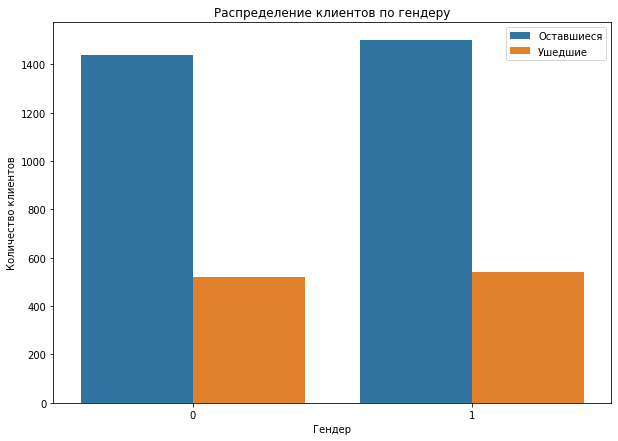

In [12]:
# строим график распределения клиентов по гендеру
plt.figure(figsize=(10, 7))
sns.countplot(x='gender', hue='churn', data=df)
plt.xlabel('Гендер')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по гендеру')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

Распределение клиентов по гендеру равномерное. Доля ушедших клиентов составляет 26 и 27 % для двух гендеров.

**Работа или проживание рядом с фитнес-центром**

In [13]:
# создаем сводную таблицу с указанием доли ушедших клиентов в зависимости от того, проживает или работает ли клиент рядом
near_location_count = df.groupby(['near_location']).agg({'churn': ['count', 'sum']}).reset_index()
near_location_count.columns = ['near_location', 'total_clients', 'churn_clients']
near_location_count['churn_rate'] = round(near_location_count['churn_clients'] / near_location_count['total_clients'], 2)
near_location_count

,near_location,total_clients,churn_clients,churn_rate
0,0,619,246,0.40
1,1,3381,815,0.24


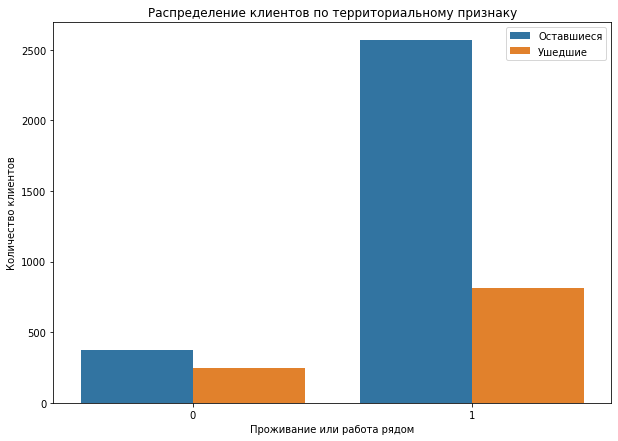

In [14]:
# строим график распределения клиентов по территориальному признаку
plt.figure(figsize=(10, 7))
sns.countplot(x='near_location', hue='churn', data=df)
plt.xlabel('Проживание или работа рядом')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по территориальному признаку')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

Большинство клиентов работают или проживают рядом с фитнес-центром. При этом доля ушедших выше среди тех, кто не обладает этим признаком (40% против 24%).

**Сотрудник компании-партнера**

In [15]:
# создаем сводную таблицу с указанием доли ушедших клиентов в зависимости от того, является ли клиент сотрудником компании-партнера
partner_count = df.groupby(['partner']).agg({'churn': ['count', 'sum']}).reset_index()
partner_count.columns = ['partner', 'total_clients', 'churn_clients']
partner_count['churn_rate'] = round(partner_count['churn_clients'] / partner_count['total_clients'], 2)
partner_count

,partner,total_clients,churn_clients,churn_rate
0,0,2053,684,0.33
1,1,1947,377,0.19


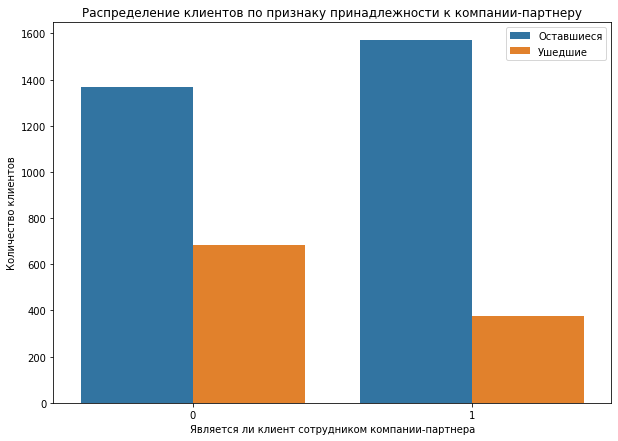

In [16]:
# строим график распределения клиентов по признаку принадлежности к компании-партнеру
plt.figure(figsize=(10, 7))
sns.countplot(x='partner', hue='churn', data=df)
plt.xlabel('Является ли клиент сотрудником компании-партнера')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по признаку принадлежности к компании-партнеру')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

Доля ушедших клиентов ниже среди тех клиентов, которые являются сотрудниками компаний-партнеров (19% против 33%).

**Покупка абонемента в рамках промо-акции**

In [17]:
# создаем сводную таблицу с указанием доли ушедших клиентов в зависимости от того, куплен ли абонемент в рамках промо-акции
promo_friends_count = df.groupby(['promo_friends']).agg({'churn': ['count', 'sum']}).reset_index()
promo_friends_count.columns = ['promo_friends', 'total_clients', 'churn_clients']
promo_friends_count['churn_rate'] = round(promo_friends_count['churn_clients'] / promo_friends_count['total_clients'], 2)
promo_friends_count

,promo_friends,total_clients,churn_clients,churn_rate
0,0,2766,866,0.31
1,1,1234,195,0.16


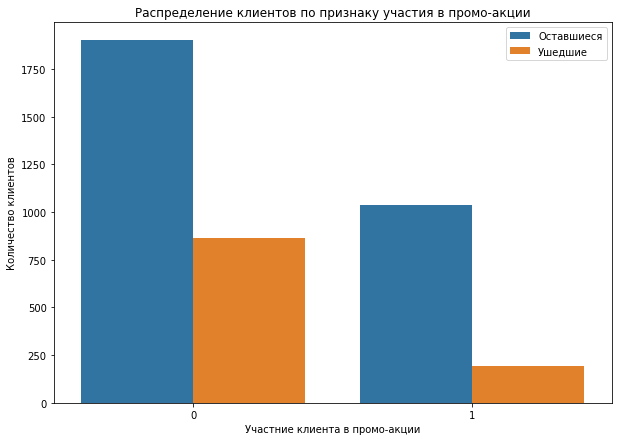

In [18]:
# строим график распределения клиентов по признаку участия в промо-акции
plt.figure(figsize=(10, 7))
sns.countplot(x='promo_friends', hue='churn', data=df)
plt.xlabel('Участние клиента в промо-акции')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по признаку участия в промо-акции')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

Среди клиентов тех кто участвовал в промо-акции меньше. Но доля ушедших в этой категории меньше - 16% против 31%.

**Наличие телефона**

In [19]:
# создаем сводную таблицу с указанием доли ушедших клиентов в зависимости от того, есть ли в базе телефонный номер
phone_count = df.groupby(['phone']).agg({'churn': ['count', 'sum']}).reset_index()
phone_count.columns = ['phone', 'total_clients', 'churn_clients']
phone_count['churn_rate'] = round(phone_count['churn_clients'] / phone_count['total_clients'], 2)
phone_count

,phone,total_clients,churn_clients,churn_rate
0,0,386,103,0.27
1,1,3614,958,0.27


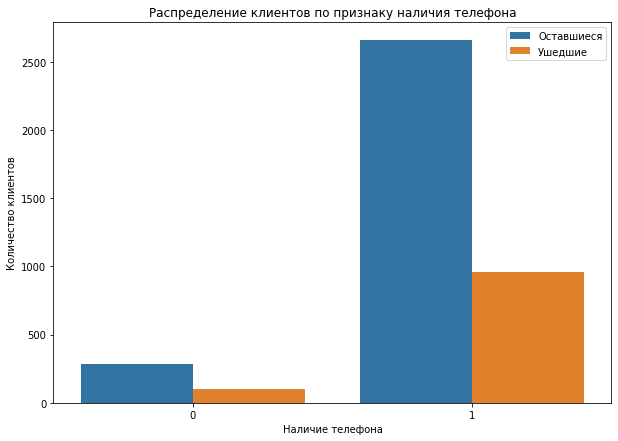

In [20]:
# строим график распределения клиентов по признаку наличия телефона
plt.figure(figsize=(10, 7))
sns.countplot(x='phone', hue='churn', data=df)
plt.xlabel('Наличие телефона')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по признаку наличия телефона')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

Доля ушедших в этой категории одинакова для всех клиентов - 27%.

**Длительность абонемента**

In [21]:
# создаем сводную таблицу с указанием доли ушедших клиентов в зависимости от длительности абонемента
contract_period_count = df.groupby(['contract_period']).agg({'churn': ['count', 'sum']}).reset_index()
contract_period_count.columns = ['contract_period', 'total_clients', 'churn_clients']
contract_period_count['churn_rate'] = round(contract_period_count['churn_clients'] / contract_period_count['total_clients'], 2)
contract_period_count

,contract_period,total_clients,churn_clients,churn_rate
0,1,2207,934,0.42
1,6,833,104,0.12
2,12,960,23,0.02


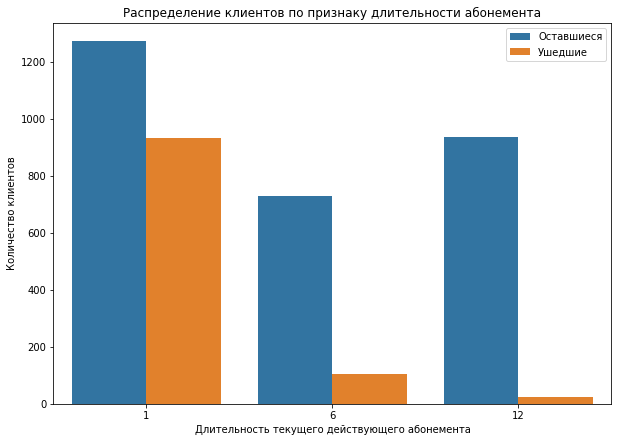

In [22]:
# строим график распределения клиентов по признаку длительности абонемента
plt.figure(figsize=(10, 7))
sns.countplot(x='contract_period', hue='churn', data=df)
plt.xlabel('Длительность текущего действующего абонемента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по признаку длительности абонемента')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

В данном случае чем больше длительность абонемента, тем меньше доля уходящих клиентов. Для абонемента в 12 месяцев доля ушедших клиентов составляет всего 2%. А для длительности в 1 месяц доля составляет 42%.

**Посещение групповых занятий**

In [23]:
# создаем сводную таблицу с указанием доли ушедших клиентов в зависимости от факта посещения групповых занятий
group_visits_count = df.groupby(['group_visits']).agg({'churn': ['count', 'sum']}).reset_index()
group_visits_count.columns = ['group_visits', 'total_clients', 'churn_clients']
group_visits_count['churn_rate'] = round(group_visits_count['churn_clients'] / group_visits_count['total_clients'], 2)
group_visits_count

,group_visits,total_clients,churn_clients,churn_rate
0,0,2351,776,0.33
1,1,1649,285,0.17


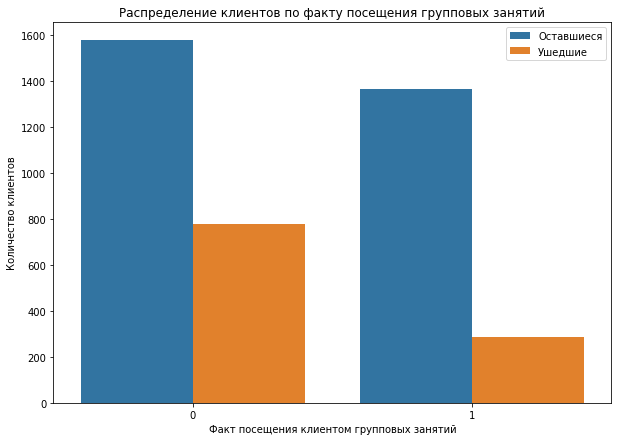

In [24]:
# строим график распределения клиентов по признаку посещения групповых занятий
plt.figure(figsize=(10, 7))
sns.countplot(x='group_visits', hue='churn', data=df)
plt.xlabel('Факт посещения клиентом групповых занятий')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по факту посещения групповых занятий')
plt.legend(['Оставшиеся', 'Ушедшие'])
plt.show()

Среди тех, кто посещает групповые занятия, доля ушедших меньше 17% против 33%.

**Возраст**

In [25]:
# ушедшие клиенты
churn_clients = df[df['churn']==1] 
# оставшиеся клиенты
stayed_clients = df[df['churn']==0] 

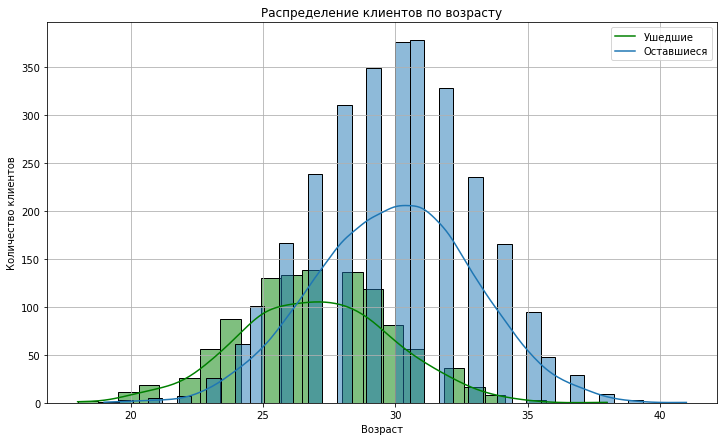

In [26]:
# строим график распределения клиентов по возрасту
fig, ax = plt.subplots(figsize=(12, 7)) 
plt.title('Распределение клиентов по возрасту')
sns.histplot(churn_clients['age'], color="g", kde=True)
sns.histplot(stayed_clients['age'], kde=True)
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.legend(['Ушедшие', 'Оставшиеся'])
plt.grid()
plt.show()

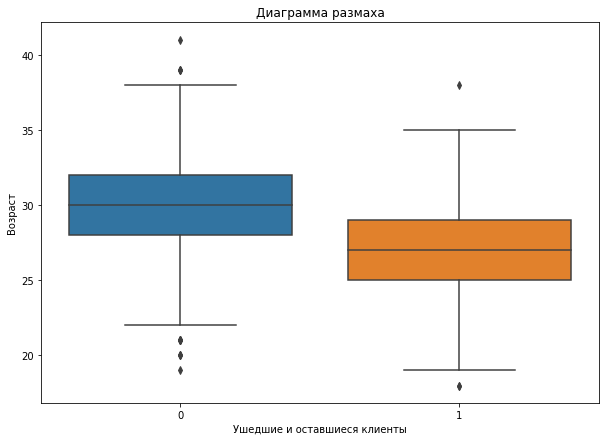

In [27]:
# диаграмма размаха возраста среди оставшихся и ушедших клиентов
plt.figure(figsize=(10, 7))
sns.boxplot(x='churn', y='age', data=df) 
plt.xlabel('Ушедшие и оставшиеся клиенты')
plt.ylabel('Возраст')
plt.title('Диаграмма размаха')
plt.show()

Среди оставшихся клиентов средний возраст выше и составляет 30 лет. Среди ушедших средний возраст составляет 27 лет.

**Суммарная выручка от других услуг фитнес-центра**

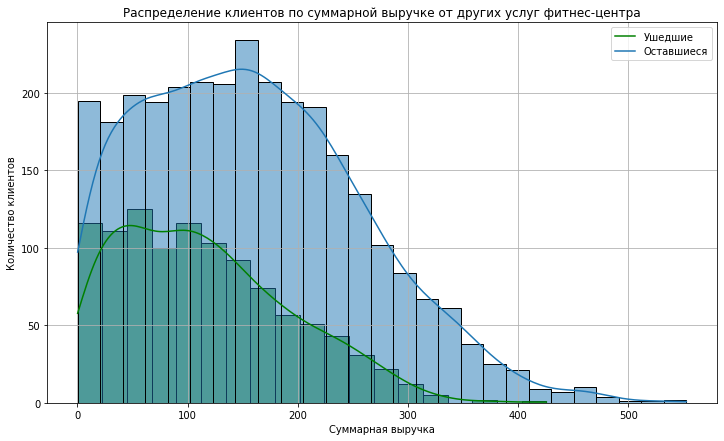

In [28]:
# строим график распределения клиентов по суммарной выручке
fig, ax = plt.subplots(figsize=(12, 7)) 
plt.title('Распределение клиентов по суммарной выручке от других услуг фитнес-центра')
sns.histplot(churn_clients['avg_additional_charges_total'], color="g", kde=True)
sns.histplot(stayed_clients['avg_additional_charges_total'], kde=True)
plt.xlabel('Суммарная выручка')
plt.ylabel('Количество клиентов')
plt.legend(['Ушедшие', 'Оставшиеся'])
plt.grid()
plt.show()

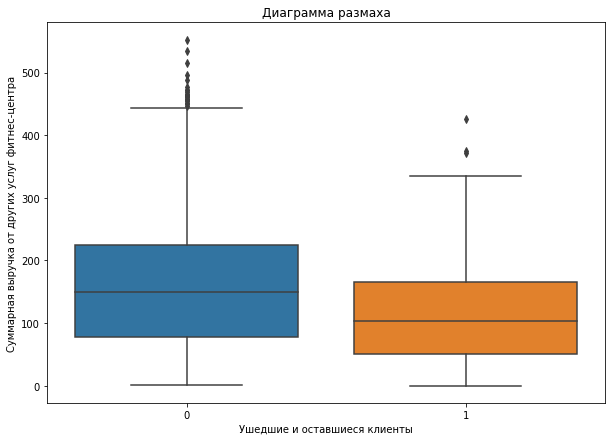

In [29]:
# диаграмма размаха суммарной выручки среди оставшихся и ушедших клиентов
plt.figure(figsize=(10, 7))
sns.boxplot(x='churn', y='avg_additional_charges_total', data=df) 
plt.xlabel('Ушедшие и оставшиеся клиенты')
plt.ylabel('Суммарная выручка от других услуг фитнес-центра')
plt.title('Диаграмма размаха')
plt.show()

Среди ушедших средняя суммарная выручка составляет 110 у.е., среди оставшихся 150 у.е.

**Срок до окончания действия абонемента в месяцах**

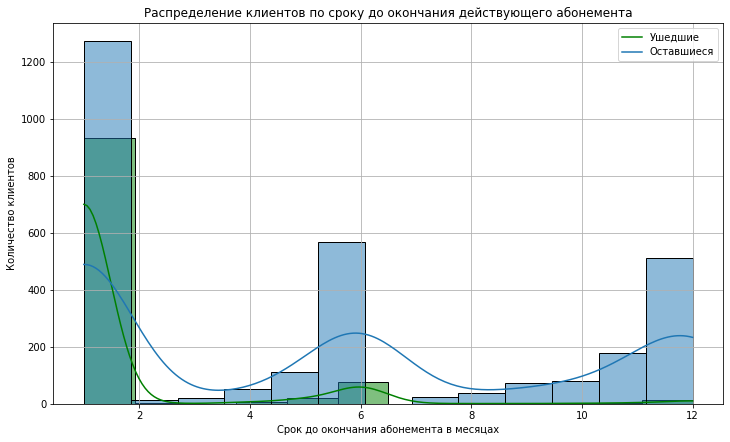

In [30]:
# строим график распределения клиентов по сроку до окончания абонемента
fig, ax = plt.subplots(figsize=(12, 7)) 
plt.title('Распределение клиентов по сроку до окончания действующего абонемента')
sns.histplot(churn_clients['month_to_end_contract'], color="g", kde=True)
sns.histplot(stayed_clients['month_to_end_contract'], kde=True)
plt.xlabel('Срок до окончания абонемента в месяцах')
plt.ylabel('Количество клиентов')
plt.legend(['Ушедшие', 'Оставшиеся'])
plt.grid()
plt.show()

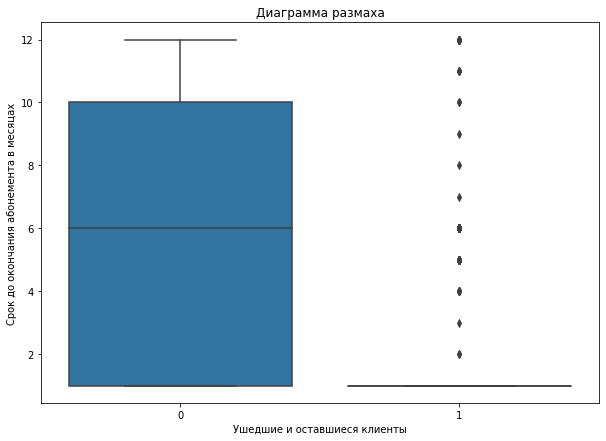

In [31]:
# диаграмма размаха срока до окончания абонемента среди оставшихся и ушедших клиентов
plt.figure(figsize=(10, 7))
sns.boxplot(x='churn', y='month_to_end_contract', data=df) 
plt.xlabel('Ушедшие и оставшиеся клиенты')
plt.ylabel('Срок до окончания абонемента в месяцах')
plt.title('Диаграмма размаха')
plt.show()

Среднее значение срока до окончания абонемента среди оставшихся клиентов - 6 месяцев, среди ушедших - 1 месяц.

**Лайфтайм**

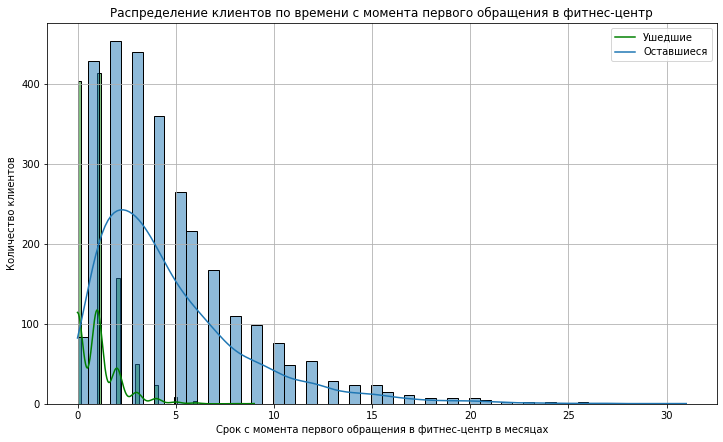

In [32]:
# строим график распределения клиентов по лайфтайму
fig, ax = plt.subplots(figsize=(12, 7)) 
plt.title('Распределение клиентов по времени с момента первого обращения в фитнес-центр')
sns.histplot(churn_clients['lifetime'], color="g", kde=True)
sns.histplot(stayed_clients['lifetime'], kde=True)
plt.xlabel('Срок с момента первого обращения в фитнес-центр в месяцах')
plt.ylabel('Количество клиентов')
plt.legend(['Ушедшие', 'Оставшиеся'])
plt.grid()
plt.show()

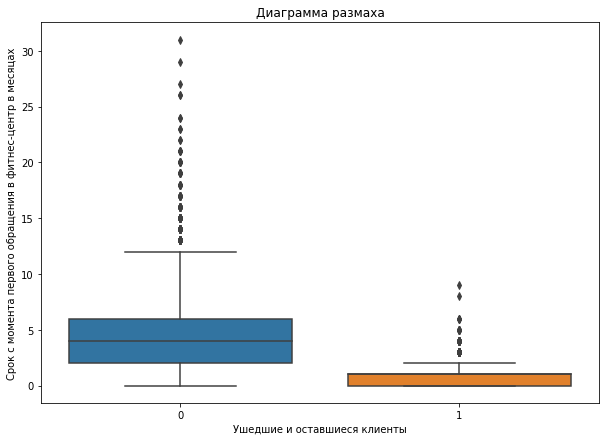

In [33]:
# диаграмма размаха лайфтайма среди оставшихся и ушедших клиентов
plt.figure(figsize=(10, 7))
sns.boxplot(x='churn', y='lifetime', data=df) 
plt.xlabel('Ушедшие и оставшиеся клиенты')
plt.ylabel('Срок с момента первого обращения в фитнес-центр в месяцах')
plt.title('Диаграмма размаха')
plt.show()

Среди оставшихся клиентов есть те, кто посещает фитнес-центр более 30 месяцев, среднее значение составляет 4 месяца. Среди ушедших клиентов максимальное значение лайфтайма составляет 10 месяцев, среднее значение составляет 1 месяц.

**Средняя частота посещений в неделю за все время**

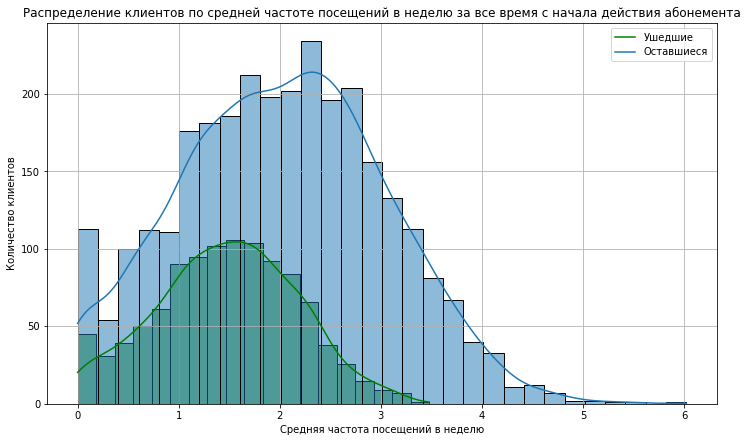

In [34]:
# строим график распределения клиентов по частоте посещений за все время
fig, ax = plt.subplots(figsize=(12, 7)) 
plt.title('Распределение клиентов по средней частоте посещений в неделю за все время с начала действия абонемента')
sns.histplot(churn_clients['avg_class_frequency_total'], color="g", kde=True)
sns.histplot(stayed_clients['avg_class_frequency_total'], kde=True)
plt.xlabel('Средняя частота посещений в неделю')
plt.ylabel('Количество клиентов')
plt.legend(['Ушедшие', 'Оставшиеся'])
plt.grid()
plt.show()

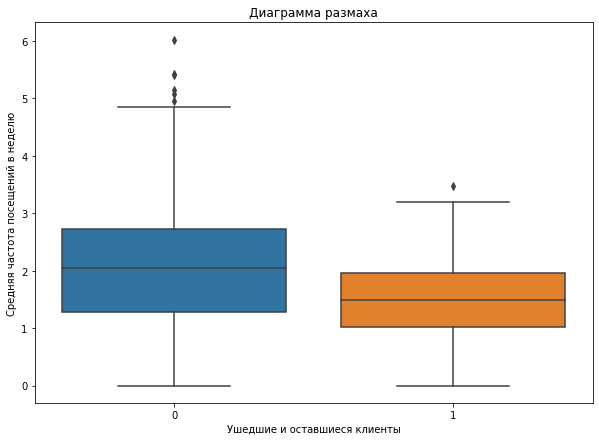

In [35]:
# диаграмма размаха частоты посещений за все время среди оставшихся и ушедших клиентов
plt.figure(figsize=(10, 7))
sns.boxplot(x='churn', y='avg_class_frequency_total', data=df) 
plt.xlabel('Ушедшие и оставшиеся клиенты')
plt.ylabel('Средняя частота посещений в неделю')
plt.title('Диаграмма размаха')
plt.show()

Оставшиеся клиенты чаще посещали фитнес-центр: в среднем 2 раза в неделю. Среди этих клиентов есть те, кто посещает фитнес-центр 6 раз в неделю. Ушедшие клиенты в среднем посещали центр 1.5 раза в неделю.

**Средняя частота посещений в неделю за предыдущий месяц**

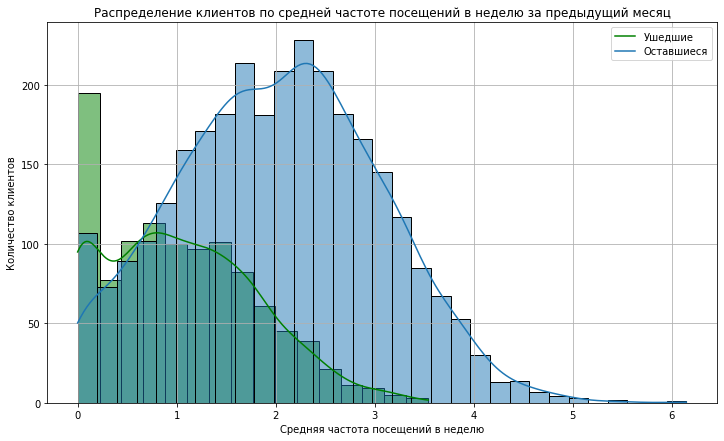

In [36]:
# строим график распределения клиентов по частоте посещений за предыдущий месяц
fig, ax = plt.subplots(figsize=(12, 7)) 
plt.title('Распределение клиентов по средней частоте посещений в неделю за предыдущий месяц')
sns.histplot(churn_clients['avg_class_frequency_current_month'], color="g", kde=True)
sns.histplot(stayed_clients['avg_class_frequency_current_month'], kde=True)
plt.xlabel('Средняя частота посещений в неделю')
plt.ylabel('Количество клиентов')
plt.legend(['Ушедшие', 'Оставшиеся'])
plt.grid()
plt.show()

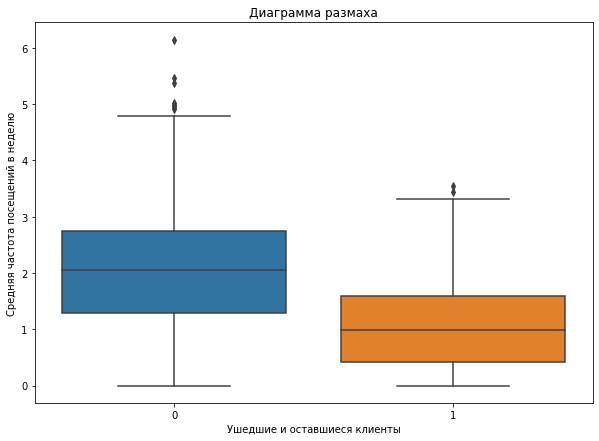

In [37]:
# диаграмма размаха частоты посещений за предыдущий месяц среди оставшихся и ушедших клиентов
plt.figure(figsize=(10, 7))
sns.boxplot(x='churn', y='avg_class_frequency_current_month', data=df) 
plt.xlabel('Ушедшие и оставшиеся клиенты')
plt.ylabel('Средняя частота посещений в неделю')
plt.title('Диаграмма размаха')
plt.show()

Средняя частота посещений в неделю за предыдущий месяц снизилась до 1 раза для ушедших клиентов.

**Матрица корреляций**

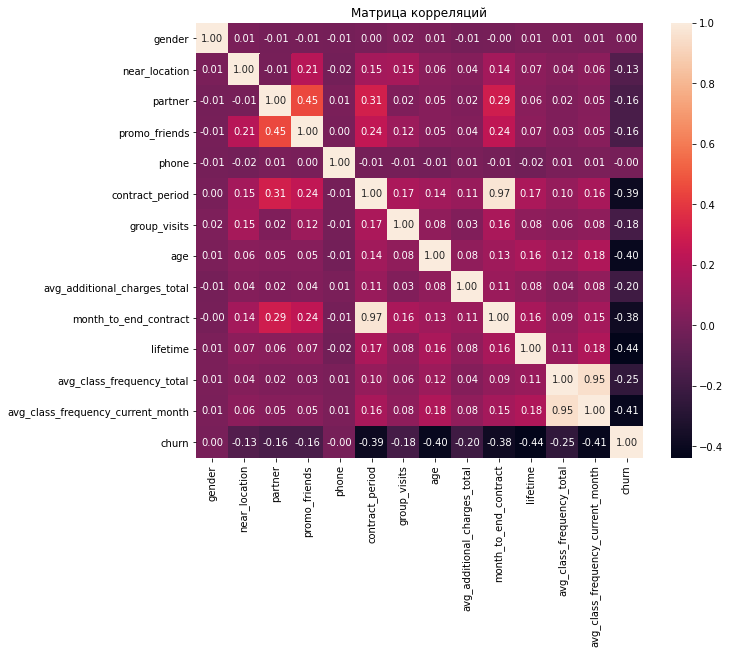

In [38]:
plt.figure(figsize=(10, 8))
plt.title('Матрица корреляций')
sns.heatmap(df.corr(), annot = True, fmt='.2f')
plt.show()

Судя по матрице корреляции признак churn (остался или ушел клиент) не зависит от гендера и наличия телефонного номера. Высокая корреляция наблюдается в парах: month_to_end_contract и contract_period, avg_class_frequency_total и avg_class_frequency_current_month. Удалим по одному признаку из каждой пары для того, чтобы при обучении модели эти признаки не искажали результаты.

In [39]:
df_filtered = df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1)

## Модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

In [40]:
# разделим данные на признаки (матрица X) и целевую переменную (y)
X = df_filtered.drop('churn', axis=1)
y = df_filtered['churn']

Разобьем данные на обучающую и валидационную выборки в соотношении 80% к 20%.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [42]:
# cтандартизируем данные
scaler = StandardScaler()
scaler.fit(X_train)

X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

**Логистическая регрессия**

In [43]:
# зададим алгоритм для модели
LR_model = LogisticRegression(random_state=0, solver='liblinear')                             
                              
                              
# обучим модель
LR_model.fit(X_train, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
LR_predictions = LR_model.predict(X_test)
LR_probabilities = LR_model.predict_proba(X_test)[:,1]

In [44]:
# печать метрик для модели
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, LR_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, LR_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, LR_predictions)))

Accuracy: 0.91
Precision: 0.85
Recall: 0.82


**Случайный лес**

In [45]:
# зададим алгоритм для модели
RFC_model = RandomForestClassifier(random_state=0)

# обучим модель
RFC_model.fit(X_train_st, y_train)

# воспользуемся обученной моделью, чтобы сделать прогнозы
RFC_predictions = RFC_model.predict(X_test_st)
RFC_probabilities = RFC_model.predict_proba(X_test_st)[:,1]

In [46]:
# печать метрик для модели
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, RFC_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, RFC_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, RFC_predictions)))

Accuracy: 0.91
Precision: 0.85
Recall: 0.77


Показатели Accuracy и Precision (доля правильных ответов и точность) имеют одинаковые значения для двух моделей. И эти показатели высокие. Показатель Recall (полнота) выше для модели "Логистическая регрессия" - 0.82 против 0.77. Таким образом модель "Логистическая регрессия" является более предпочтительной.

## Кластеризация клиентов

**Агломеративная иерархическая кластеризация**

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

In [47]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# строим матрицу расстояний
linked = linkage(X_sc, method = 'ward') 

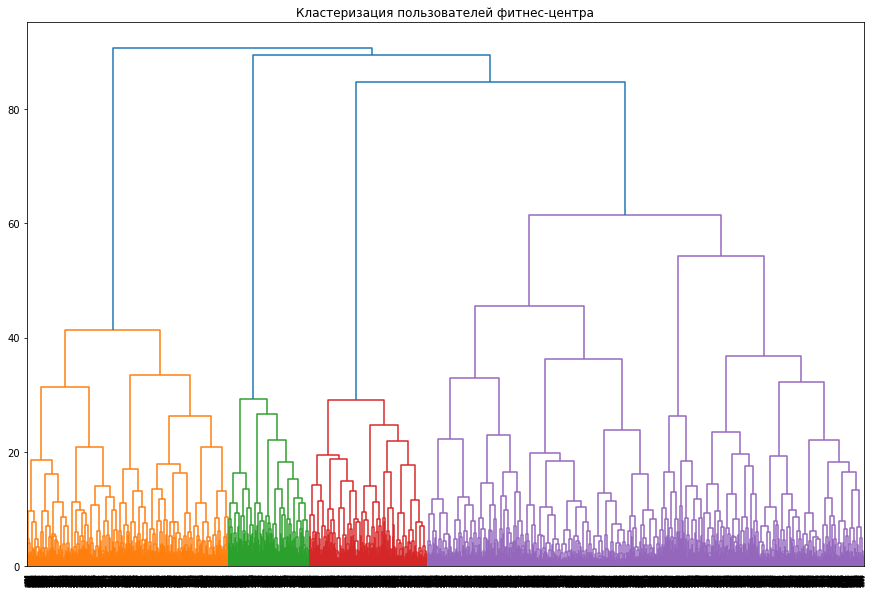

In [48]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-центра')
plt.show() 

На дендрограмме выделились 4 кластера.

**K-Means**

Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5.

In [49]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc) 
# сохраняем метки кластера в поле нашего датасета
df_filtered['cluster'] = labels
df_filtered.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,0


In [50]:
# создаем сводную таблицу со средними значениями признаков по кластерам
clusters = pd.DataFrame(df_filtered.groupby(['cluster']).mean()).T
clusters

cluster,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


По сводной таблице можно сделать выводы:
- гендер распределен по всем кластерам равномерно;
- клиенты из 1-ого кластера не живут и не работают рядом с фитнес-центром;
- клиенты из 2-ого и 3-его кластеров в наименьшей степени являются сотрудниками компаний-партнеров;
- все клиенты из 0-ого кластера купили абонемент в рамках промо-акции;
- для клиентов из 4-ого кластера отсутствует телефонный номер;
- клиенты из 0-ого и 3-его кластера выбрали более длительный абонемент;
- 1-ый и 2-ой кластеры меньше всего посещают групповые занятия;
- возраст распределен равномерно;
- доход от других услуг имеет наименьшее значение во 2-ом кластере;
- наименьший лайфтайм характер для 2-ого кластера, а наибольший для 3-его;
- чаще всего фитнес-центр посещают клиенты из 3-его кластера;
- наибольший отток клиентов характерен для 2-ого кластера.

In [51]:
# посмотрим на объем кластеров
df_filtered.cluster.value_counts()

2    1064
3    1007
0     985
1     558
4     386
Name: cluster, dtype: int64

**Распределения признаков для кластеров**

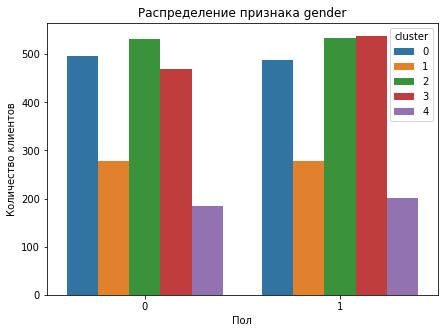

In [52]:
# строим график распределения признака gender
plt.figure(figsize=(7, 5))
plt.title('Распределение признака gender')
sns.countplot(x = df_filtered['gender'], hue='cluster', data=df_filtered)
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.show()

Пол распределен по кластерам равномерно.

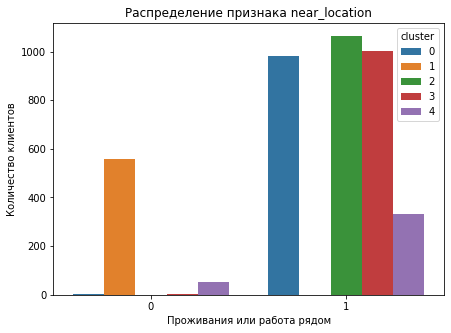

In [53]:
# строим график распределения признака near_location
plt.figure(figsize=(7, 5))
plt.title('Распределение признака near_location')
sns.countplot(x = df_filtered['near_location'], hue='cluster', data=df_filtered)
plt.xlabel('Проживания или работа рядом')
plt.ylabel('Количество клиентов')
plt.show()

Весь первый кластер не работает и не проживает рядом с фитнес-центром.

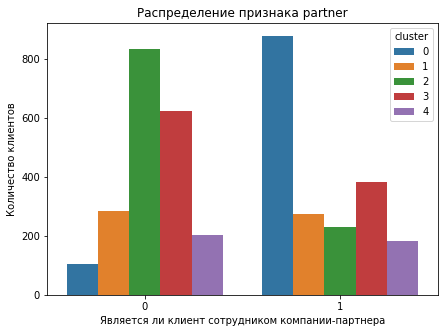

In [54]:
# строим график распределения признака partner
plt.figure(figsize=(7, 5))
plt.title('Распределение признака partner')
sns.countplot(x = df_filtered['partner'], hue='cluster', data=df_filtered)
plt.xlabel('Является ли клиент сотрудником компании-партнера')
plt.ylabel('Количество клиентов')
plt.show()

1-ый и 4-ый кластеры распределены примерно одинаково. По графику видно, что клиенты 0-ого кластера чаще являются сотрудниками компаний-партнеров. У 2-ого и 3-его кластера противоположная ситуация.

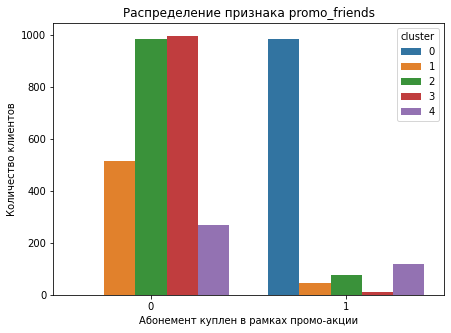

In [55]:
# строим график распределения признака promo_friends
plt.figure(figsize=(7, 5))
plt.title('Распределение признака promo_friends')
sns.countplot(x = df_filtered['promo_friends'], hue='cluster', data=df_filtered)
plt.xlabel('Абонемент куплен в рамках промо-акции')
plt.ylabel('Количество клиентов')
plt.show()

Клиенты 0-ого кластера купили абонемент только в рамках промо-акции. Для остальных кластеров больше характерна покупка абонемента вне акции. 

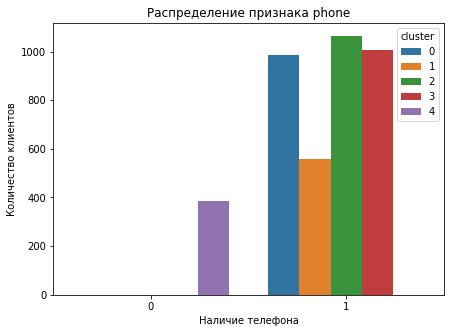

In [56]:
# строим график распределения признака phone
plt.figure(figsize=(7, 5))
plt.title('Распределение признака phone')
sns.countplot(x = df_filtered['phone'], hue='cluster', data=df_filtered)
plt.xlabel('Наличие телефона')
plt.ylabel('Количество клиентов')
plt.show()

Для клиентов из 4-ого кластера характерно отсутствие телефонного номера.

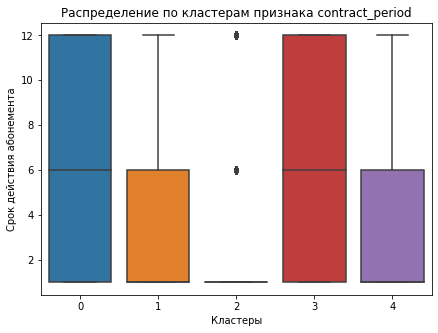

In [57]:
# строим график распределения признака contract_period
plt.figure(figsize=(7, 5))
plt.title('Распределение по кластерам признака contract_period')
sns.boxplot(x='cluster',y='contract_period', data=df_filtered)
plt.xlabel('Кластеры')
plt.ylabel('Срок действия абонемента')
plt.show()

Для клиентов из 2-ого кластера характерено приобретение абонемента на наименьший срок.

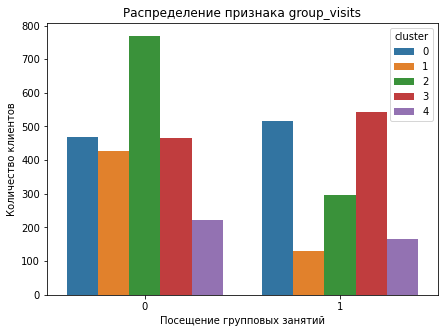

In [58]:
# строим график распределения признака group_visits
plt.figure(figsize=(7, 5))
plt.title('Распределение признака group_visits')
sns.countplot(x = df_filtered['group_visits'], hue='cluster', data=df_filtered)
plt.xlabel('Посещение групповых занятий')
plt.ylabel('Количество клиентов')
plt.show()

Клиенты из 1-ого, 2-ого и 4-ого кластеров реже посещают групповые занятия.

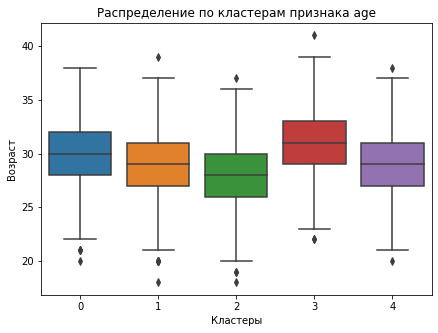

In [59]:
# строим график распределения признака age
plt.figure(figsize=(7, 5))
plt.title('Распределение по кластерам признака age')
sns.boxplot(x='cluster',y='age', data=df_filtered)
plt.xlabel('Кластеры')
plt.ylabel('Возраст')
plt.show()

Старше всех клиенты из 3-его кластера, самые младшие - 2-ой кластер.

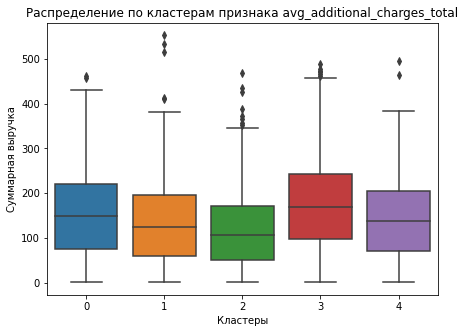

In [60]:
# строим график распределения признака avg_additional_charges_total
plt.figure(figsize=(7, 5))
plt.title('Распределение по кластерам признака avg_additional_charges_total')
sns.boxplot(x='cluster',y='avg_additional_charges_total', data=df_filtered)
plt.xlabel('Кластеры')
plt.ylabel('Суммарная выручка')
plt.show()

Самая высокая выручка от других услуг фитнес-центра от клиентов 3-его кластера, самая низкая от 2-ого.

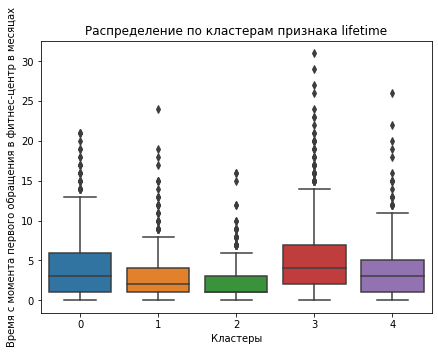

In [61]:
# строим график распределения признака lifetime
plt.figure(figsize=(7, 5))
plt.title('Распределение по кластерам признака lifetime')
sns.boxplot(x='cluster',y='lifetime', data=df_filtered)
plt.xlabel('Кластеры')
plt.ylabel('Время с момента первого обращения в фитнес-центр в месяцах')
plt.show()

Наибольший лайфтайм у 3-его кластера, наименьший у второго.

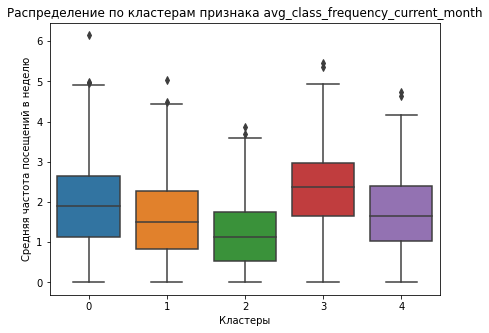

In [62]:
# строим график распределения признака avg_class_frequency_current_month
plt.figure(figsize=(7, 5))
plt.title('Распределение по кластерам признака avg_class_frequency_current_month')
sns.boxplot(x='cluster',y='avg_class_frequency_current_month', data=df_filtered)
plt.xlabel('Кластеры')
plt.ylabel('Средняя частота посещений в неделю')
plt.show()

Частота посещения в неделю фитнес-центра за предыдущий месяц выше у 3-его кластера, самый низкий показатель у 2-ого кластера.

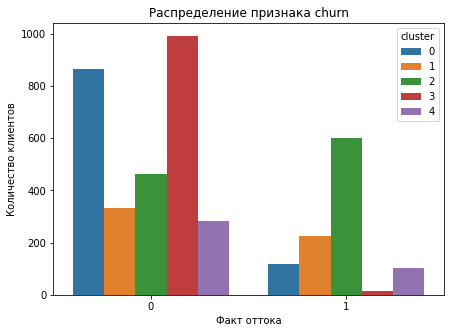

In [63]:
# строим график распределения признака churn
plt.figure(figsize=(7, 5))
plt.title('Распределение признака churn')
sns.countplot(x = df_filtered['churn'], hue='cluster', data=df_filtered)
plt.xlabel('Факт оттока')
plt.ylabel('Количество клиентов')
plt.show()

3-ий кластер имеет наименьший отток клиентов, чаще уходят клиенты 2-ого кластера.

**Доля оттока клиентов для каждого кластера**

In [64]:
# создаем сводную таблицу для каждого кластера с общим количеством клиентов, 
# количеством ушедших клиентов, долей ушедших клиентов
ratio_by_churn = df_filtered.pivot_table(index='cluster', values='churn', aggfunc=['count', 'sum'])
ratio_by_churn.columns = ['count', 'sum']
ratio_by_churn['ratio'] = round(ratio_by_churn['sum'] / df_filtered['churn'].sum(), 2)
ratio_by_churn

,count,sum,ratio
cluster,,,
0,985,118,0.11
1,558,225,0.21
2,1064,600,0.57
3,1007,15,0.01
4,386,103,0.10


Больше половины всех ушедших клиентов приходится на 2-ой кластер, самые надежные клиенты в 3-ем кластере.

## Выводы и базовые рекомендации по работе с клиентами

В ходе данного исследования были построены модели прогнозирования оттока клиентов методами "Логистическая регрессия" и "Случайные лес". Первая модель оказалась более предпочтительной.

Далее была произведена кластеризация всех клиентов, в результате которой можно сделать вывод, что наиболее надежными клиентами являются:
- те, кто живут или работают рядом с фитнес-центром;
- имеют абонементы с более длительным сроком действия;
- чаще оставляют телефонный номер;
- чаще посещают групповые занятия;
- имеют средний возраст чуть более 30 лет;
- тратят больше денежных средств на другие услуги фитнес-центра;
- имеют более высокий лайфтайм;
- имеют более высокую среднюю частоту посещений за неделю.

Так же стоит отметить, что для клиентов, которые покинули фитнес-центр наиболее характерны:
- абонементы длительностью 1 месяц;
- самый молодой средний возраст;
- наименьшая выручка от других услуг;
- наименьший лайфтайм;
- наименьшая частота посещений фитнес-центра в неделю.

Из вышеизложенного для привлечения наиболее лояльных клиентов можно сформулировать следующие рекомендации:
- реклама, которая позволит охватить наибольшее количество потенциальных клиентов, живущих или работающих рядом;
- стимулировать покупку более длительных абонементов, возможно за счет скидок;
- уделять больше внимания качеству групповых занятий, информировать клиентов о наличии таковых;
- расширение других услуг фитнес-центра и контроль качества, как показало исследование надежные клиенты чаще пользуются такими услугами.


